## Import statements

In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import networkx as nx
from itertools import product
from functools import lru_cache

%matplotlib inline

## Variables setup

The next variable will be the text we need to predict

In [2]:
l = 'apple'

Next we define the maximum number of output (timesteps) of our model

In [3]:
T = 8

The next variable indicate the number of unique labels we are using (our alphabet)

In [4]:
L = ''.join(sorted(list(frozenset(l))))

We add to our alphabet a extra character (blank space)

In [5]:
L_ext = L + ' '

Now add blank spaces between each pair of characters in the text. Also at the beginning & at the end

In [6]:
l_ext = ' ' + ' '.join(l) + ' '

In [7]:
l_ext, L_ext

(' a p p l e ', 'aelp ')

The next variable (y) is a representation of a possible output of the model.<br/>
It is a matrix of size Txn where T is the maximum number of timesteps and n is the number of
characters we are using (including blank space)

Each vector y[k, :] is the output of a softmax layer. The sum of all the elements is 1. Each item y[k, j] indicates the probability of watching the label j at the timestep k

In [8]:
y = np.array([
    [1, 0, 0, 0, 0],
    [1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1],
    [0, 0, 0, 1, 0],
    [0, 0, 1, 0, 0],
    [0, 1, 0, 0, 0]
], dtype=np.float64)

In [9]:
#y = np.random.random([T, len(L_ext)])

In [10]:
y = np.divide(y, y.sum(axis=1).reshape([-1, 1]))

In [11]:
y.shape

(8, 5)

This is the text our model predicts (without CTC decodification)

In [13]:
'Predicted text: "' + ''.join([L_ext[k] for k in np.argmax(y, axis=1)]) + '"'

'Predicted text: "aa p ple"'

## Calculate CTC forward variables

Alpha and beta values can be used to compute the loss function and its derivative so that we can apply optimization via gradient descent 

Thos variables are calculated using a dynamic programming algorithm

In [14]:
def alpha(t, s):
    if t < 0 or s < 0:
        return 0
    if t == 0:
        if s == 0:
            return y[0, L_ext.index(' ')]
        if s == 1:
            return y[0, L_ext.index(l[0])]
        return 0
    
    if 2 * s + 1 < t or 2 * t + 1 < s:
        return 0
    
    def _alpha():
        return alpha(t-1, s) + alpha(t-1, s-1)
    
    p = y[t, L_ext.index(l_ext[s])]
    if l_ext[s] == ' ' or (s > 1 and l_ext[s] == l_ext[s-2]):
        return _alpha() * p
    
    return (_alpha() + alpha(t-1, s-2)) * p


A = np.zeros([T, len(l_ext)]).astype(np.float64)
for t, s in product(range(0, T), range(0, len(l_ext))):
    A[t, s] = alpha(t, s)

Finally rescale the alpha values

In [15]:
C = A.sum(axis=1)
A = np.divide(A, C.reshape([-1, 1]))

The next cell shows the alpha values where the x-axis is the timestep and the y-axis is the character

In [16]:
df = pd.DataFrame(np.round(A, decimals=3).T)
df['label'] = [label if label != ' ' else '--' for label in l_ext]
df.set_index('label', inplace=True)
df

,0,1,2,3,4,5,6,7
label,,,,,,,,
--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
a,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
--,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
p,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
--,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
p,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
l,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
--,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


The next graph shows all possible paths that are equivalent to our labels sequence

In [17]:
G = nx.DiGraph()

node_pos = {}
node_alpha = []
node_colors = []

for t, s in product(range(0, T), range(0, len(l_ext))):
    G.add_node((t, s))
    node_pos[(t, s)] = (t, len(l_ext) - s)

for t, s in G.nodes:
    if 2 * s + 1 < t or 2 * t + 1 < s:
        node_colors.append('black')
        node_alpha.append(0.1)
    else:
        node_colors.append('black')
        node_alpha.append(0.35 + A[t, s] * 0.65)

def g_alpha(t, s):
    if t == 0 and s in (0, 1):
        return True
    if (t < 0) or (s < 0) or (2 * s + 1 < t) or (2 * t + 1 < s):
        return False
    
    def _g_alpha():
        a, b = g_alpha(t-1, s), g_alpha(t-1, s-1)
        if a:
            G.add_edge((t-1, s), (t, s))
        if b:
            G.add_edge((t-1, s-1), (t, s))
        return a or b
            
    if l_ext[s] == ' ' or (s > 1 and l_ext[s] == l_ext[s-2]):
        return _g_alpha()
    
    ab, c = _g_alpha(), g_alpha(t-1, s-2)
    if c:
        G.add_edge((t-1, s-2), (t, s))
    return ab or c
            
g_alpha(T-1, len(l_ext)-1)
g_alpha(T-1, len(l_ext)-2)

True

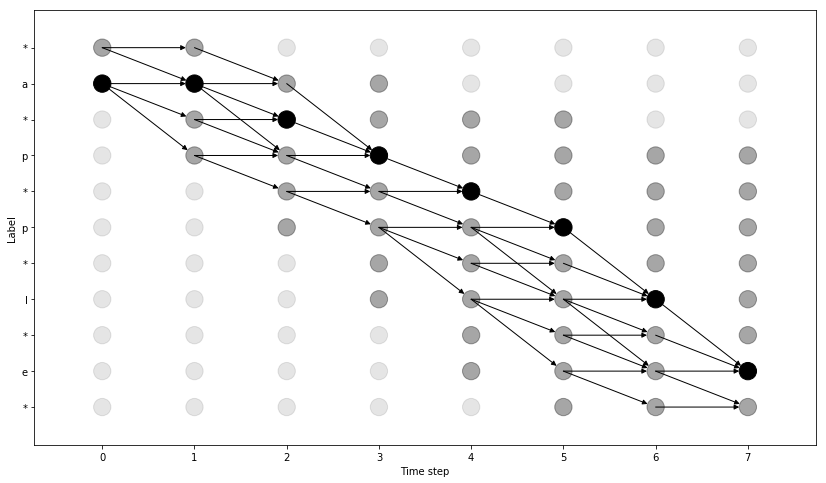

In [18]:

plt.figure(figsize=(14, 8))
nx.draw_networkx_nodes(G, pos=node_pos, node_color=node_colors, alpha=node_alpha)
nx.draw_networkx_edges(G, pos=node_pos);
plt.xlabel('Time step')
plt.ylabel('Label')
plt.yticks(range(1, len(l_ext)+1), labels=reversed(l_ext.replace(' ', '*')));

Now we can calculate the loss in our classification

In [19]:
np.log(C).sum()

0.0

## Tensorflow CTC loss function

Now we compute the CTC loss function with the tensorflow library

In [20]:
import keras.backend as K
import tensorflow as tf

Using TensorFlow backend.


We need to build an array with numeric labels corresponding to the characters of the text we want to predict

In [265]:
labels = np.array([L.index(ch) for ch in l], np.int32).reshape([1, -1])

In [266]:
labels

array([[0, 3, 3, 2, 1]], dtype=int32)

We want to make multiple predictions over the same target

In [267]:
labels = labels.repeat(5, axis=0)
labels

array([[0, 3, 3, 2, 1],
       [0, 3, 3, 2, 1],
       [0, 3, 3, 2, 1],
       [0, 3, 3, 2, 1],
       [0, 3, 3, 2, 1]], dtype=int32)

Then variable y will emulate different outputs of a LSTM layer

In [314]:
outputs = [
    '-ap-ple-',
    '-apple--',
    'apple---',
    'a-p-p-e-',
    '-p-ple--'
]

In [309]:
outputs = np.array([[L_ext.index(ch) for ch in output] for output in [output.replace('-', ' ') for output in outputs]])

y = np.zeros([labels.shape[0], output_labels.shape[1], len(L_ext)]).astype(np.float32)

for i, j in product(range(0, labels.shape[0]), range(outputs.shape[1])):
    y[i, j, outputs[i, j]] = 1

y *= 4

In [315]:
y.shape

(5, 8, 5)

In [316]:
y[0]

array([[0., 0., 0., 0., 4.],
       [4., 0., 0., 0., 0.],
       [0., 0., 0., 4., 0.],
       [0., 0., 0., 0., 4.],
       [0., 0., 0., 4., 0.],
       [0., 0., 4., 0., 0.],
       [0., 4., 0., 0., 0.],
       [0., 0., 0., 0., 4.]], dtype=float32)

In [310]:
sequence_length = np.array([y.shape[1]], dtype=np.int32).repeat(y.shape[0])

In [311]:
sequence_length

array([8, 8, 8, 8, 8], dtype=int32)

Finally we compute the CTC loss

In [313]:

losses = K.get_value(tf.nn.ctc_loss(
    tf.contrib.layers.dense_to_sparse(labels, eos_token=-1),
    y,
    sequence_length,
    preprocess_collapse_repeated=False,
    ctc_merge_repeated=False,
    time_major=False
))

In [325]:
df = pd.DataFrame.from_dict({
    'True labels': [l] * labels.shape[0],
    'Predicted labels': outputs,
    'CTC Loss': losses
})

df.sort_values(by='CTC Loss', inplace=True)

In [326]:
df

,True labels,Predicted labels,CTC Loss
0,apple,-ap-ple-,0.564253
1,apple,-apple--,0.564594
2,apple,apple---,0.564600
3,apple,a-p-p-e-,4.509822
4,apple,-p-ple--,4.546114
